# Práctica 2

Miriam Méndez y Laura Lasso

Andrea Mayor
## 1 Importación de librerías y carga de datos

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from itertools import product

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 263377453.15it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 22608378.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 133976973.98it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23035705.89it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


## 2 CNN

In [4]:
class Autoencoder_Conv(nn.Module):
    def __init__(self):
        super(Autoencoder_Conv, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Cambio a capas convolucionales
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # No hay padding aquí
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Usar Sigmoid al final si las imágenes están entre 0 y 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 11 17:10:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [7]:
# model = Autoencoder()
model = Autoencoder_Conv()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

model.to(device)

Autoencoder_Conv(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [8]:
num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.to(device)

        # Si img no tiene el canal, agrega una dimensión de canal
        if len(img.size()) == 3:
            img = img.unsqueeze(1)

        recon = model(img)  # Pasa la imagen a través del modelo
        loss = criterion(recon, img)  # Calcula la pérdida

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

# Guardar el modelo entrenado
torch.save(model.state_dict(), 'autoencoder_model.pth')

Epoch:1, Loss:0.0086
Epoch:2, Loss:0.0050
Epoch:3, Loss:0.0043
Epoch:4, Loss:0.0034
Epoch:5, Loss:0.0036
Epoch:6, Loss:0.0030
Epoch:7, Loss:0.0027
Epoch:8, Loss:0.0019
Epoch:9, Loss:0.0021
Epoch:10, Loss:0.0027


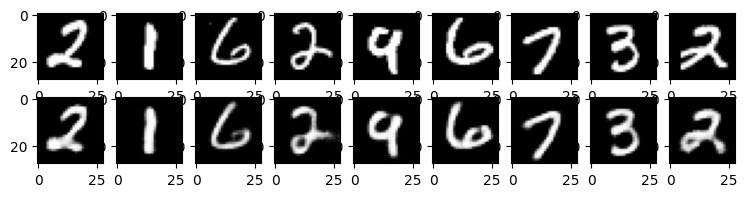

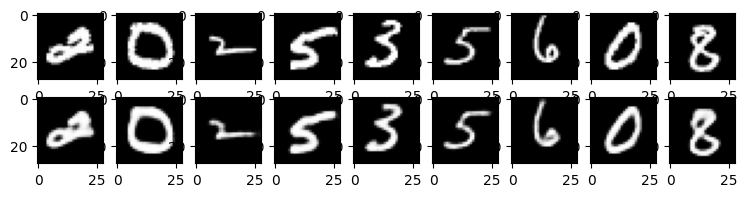

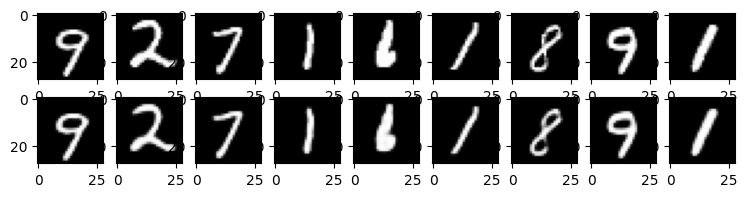

In [9]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)  # row_length + i + 1
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
    plt.show()


### 2.3 Pruebas sobre el conjunto de validación

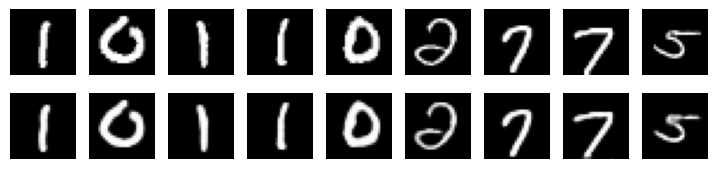

In [10]:
model.eval()  # Asegúrate de que el modelo esté en modo de evaluación

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

plt.figure(figsize=(9, 2))
plt.gray()

for i, img in enumerate(images[:9]):
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)  # Asegúrate de que la imagen tenga una dimensión de canal y esté en el dispositivo correcto
        # No necesitas aplanar la imagen: img2 = img.view(-1, 28*28)
        pred = model(img)  # Obtener la predicción del modelo
        recon = pred[0].cpu().detach().numpy()  # Mover el tensor de vuelta a la CPU para la conversión a NumPy
        recon2 = recon.reshape(28, 28)  # Cambiar la forma para visualización

        plt.subplot(2, 9, i+1)
        plt.imshow(img.cpu().squeeze(), cmap='gray')  # Muestra la imagen original, asegurándote de eliminar cualquier dimensión unitaria
        plt.axis('off')  # Ocultar los ejes

        plt.subplot(2, 9, i+1+9)
        plt.imshow(recon2, cmap='gray')  # Visualizar la reconstrucción
        plt.axis('off')  # Ocultar los ejes

plt.show()


## 3 Ejercicios
### 3.1 Primera parte

- Crea un supresor de ruido de imágenes. Añade ruido a las imágenes de entrada y compáralas a la salida con las originales. Varía los hiperparámetros y busca el mejor supresor.



Epoch:1, LR: 0.001, Weight Decay: 1e-05, Loss:0.0092
Epoch:2, LR: 0.001, Weight Decay: 1e-05, Loss:0.0054
Epoch:3, LR: 0.001, Weight Decay: 1e-05, Loss:0.0059
Epoch:4, LR: 0.001, Weight Decay: 1e-05, Loss:0.0050
Epoch:5, LR: 0.001, Weight Decay: 1e-05, Loss:0.0049
Epoch:6, LR: 0.001, Weight Decay: 1e-05, Loss:0.0048
Epoch:7, LR: 0.001, Weight Decay: 1e-05, Loss:0.0045
Epoch:8, LR: 0.001, Weight Decay: 1e-05, Loss:0.0043
Epoch:9, LR: 0.001, Weight Decay: 1e-05, Loss:0.0035
Epoch:10, LR: 0.001, Weight Decay: 1e-05, Loss:0.0038
Epoch:1, LR: 0.001, Weight Decay: 0.0001, Loss:0.0118
Epoch:2, LR: 0.001, Weight Decay: 0.0001, Loss:0.0080
Epoch:3, LR: 0.001, Weight Decay: 0.0001, Loss:0.0055
Epoch:4, LR: 0.001, Weight Decay: 0.0001, Loss:0.0053
Epoch:5, LR: 0.001, Weight Decay: 0.0001, Loss:0.0054
Epoch:6, LR: 0.001, Weight Decay: 0.0001, Loss:0.0039
Epoch:7, LR: 0.001, Weight Decay: 0.0001, Loss:0.0045
Epoch:8, LR: 0.001, Weight Decay: 0.0001, Loss:0.0044
Epoch:9, LR: 0.001, Weight Decay: 0.0

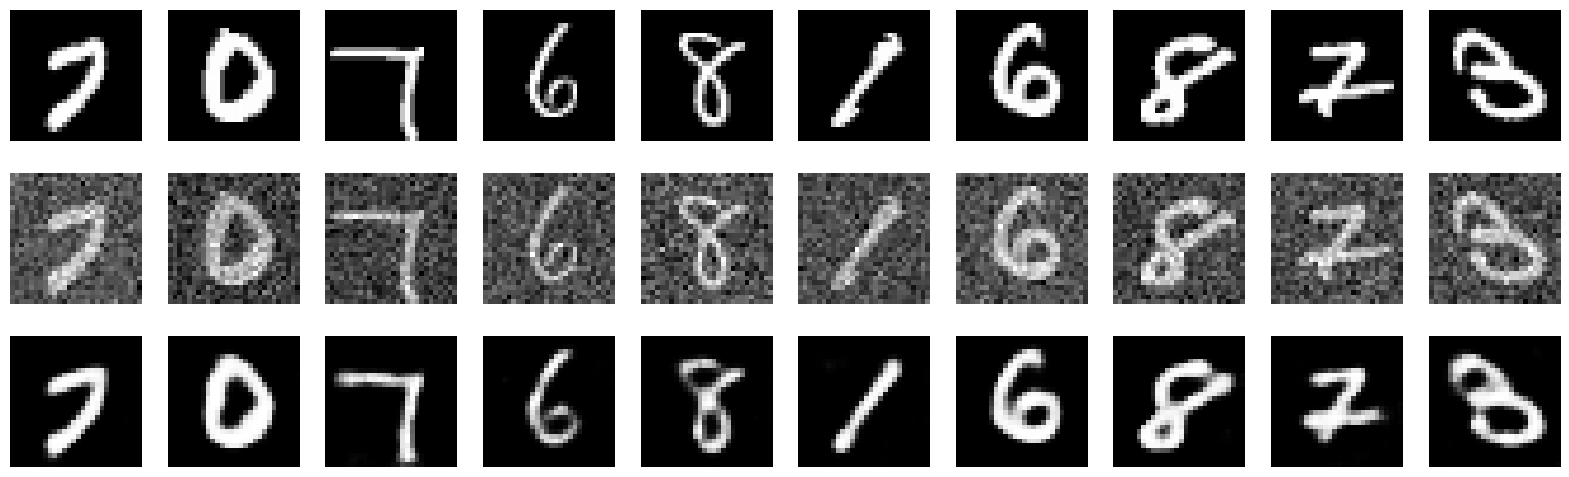

In [11]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader

# Función para agregar ruido a las imágenes
def add_noise(img):  # Add noise to the image
    noise = torch.randn(img.size()).to(device) * 0.2
    noisy_img = img + noise
    return noisy_img

# Definición de los hiperparámetros para la búsqueda en cuadrícula
tasas_de_aprendizaje = [1e-3, 5e-4, 1e-4]
decays_de_peso = [1e-5, 1e-4, 1e-3]

# Variables para almacenar los mejores hiperparámetros
mejor_perdida = float('inf')
mejores_hiperparametros = {}

# Ciclo de búsqueda en cuadrícula
for lr in tasas_de_aprendizaje:
    for wd in decays_de_peso:
        model = Autoencoder_Conv().to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
        criterion = nn.MSELoss()

        # Ciclo de entrenamiento
        num_epochs = 10
        for epoch in range(num_epochs):
            for img, _ in data_loader:
                img = img.to(device)  # Mover el tensor al dispositivo correcto
                optimizer.zero_grad()
                noisy_imgs = add_noise(img)
                recon = model(noisy_imgs)
                loss = criterion(recon, img)
                loss.backward()
                optimizer.step()

            print(f'Epoch:{epoch+1}, LR: {lr}, Weight Decay: {wd}, Loss:{loss.item():.4f}')

         # Evaluación del modelo
        model.eval()
        perdida_validacion = 0
        total_samples = 0
        with torch.no_grad():
            for (img, _) in data_loader_valid:
                img = img.to(device)
                noisy_imgs = add_noise(img)
                noisy_imgs_flat = noisy_imgs.view(-1, 28*28)
                recon = model(noisy_imgs)
                perdida_validacion += criterion(recon, img).item() * img.size(0)  # Usa la imagen original para calcular la pérdida
                total_samples += img.size(0)

        perdida_validacion /= total_samples

        # Actualización de los mejores hiperparámetros si se encontró un mejor modelo
        if perdida_validacion < mejor_perdida:
            mejor_perdida = perdida_validacion
            mejores_hiperparametros = {'tasa_de_aprendizaje': lr, 'decay_de_peso': wd}

# Imprimir los mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados: Tasa de aprendizaje = {mejores_hiperparametros['tasa_de_aprendizaje']}, "
      f"Decay de peso = {mejores_hiperparametros['decay_de_peso']}. "
      f"Pérdida de validación = {mejor_perdida}")

# Visualización de las imágenes (usando los mejores hiperparámetros encontrados)
# Visualización de las imágenes (usando los mejores hiperparámetros encontrados)
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))
with torch.no_grad():
    for i in range(10):
        # Imágenes originales
        img_orig = img[i].cpu().squeeze()  # img es una imagen del data_loader_valid
        axes[0, i].imshow(img_orig, cmap='gray')
        axes[0, i].axis('off')

        # Imágenes con ruido
        noisy_img = add_noise(img[i].unsqueeze(0).to(device))  # Añadir ruido, asegurarse de tener dimensión de canal
        axes[1, i].imshow(noisy_img.cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')

        # Imágenes reconstruidas
        recon_img = model(noisy_img).cpu().squeeze()  # Pasar la imagen con ruido directamente al modelo
        axes[2, i].imshow(recon_img, cmap='gray')
        axes[2, i].axis('off')

plt.show()


### 3.2 Parte 2: Hacer super resolución
#### 3.2.1 Definición de las funciones

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def train_model(model, criterion, optimizer, dim, num_epochs, train_loader):
        for epoch in range(num_epochs):
            for data in train_loader:
                img, _ = data
                optimizer.zero_grad()
                output = model(img)

                # Ajustar las dimensiones de la imagen de salida para que coincida con la entrada
                output = nn.functional.interpolate(output, size=(dim, dim), mode='bilinear', align_corners=False)

                loss = criterion(output, img)
                loss.backward()
                optimizer.step()

            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

def download_data(dim, batch_size=64):
        transform = transforms.Compose([
        transforms.Resize((dim, dim)),  # Ajustar el tamaño de las imágenes de entrada a 14x14
        transforms.ToTensor()])

        # Descargar el conjunto de datos MNIST
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

        # Crear DataLoader para facilitar el manejo de los datos
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        return train_dataset, train_loader

# Visualizar las imágenes originales y reconstruidas
def imshow(img, title):
        img = img.numpy().transpose((1, 2, 0))
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.show()

def visualize_results(model, train_dataset):
        # Establecer el modelo en modo de evaluación
        model.eval()

        # Obtener un lote de datos de prueba
        test_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
        test_batch, _ = next(iter(test_loader))

        # Realizar la inferencia en el lote de prueba
        with torch.no_grad():
          reconstructed_batch = model(test_batch)
        # Visualizar imágenes originales
        imshow(torchvision.utils.make_grid(test_batch), "Original Images")

        # Visualizar imágenes reconstruidas
        imshow(torchvision.utils.make_grid(reconstructed_batch), "Reconstructed Images")

#### 3.2.2 Entrada 14x14 y salida 28x28
##### 3.2.2.1 Definición de la CNN, entrenamiento y visualización de resultados

In [13]:
# Definir el modelo con encoder y decoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            #nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
dim = 14
train_dataset, train_loader = download_data(dim)

# Instanciar el modelo
autoencoder = Autoencoder()

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
num_epochs = 10

# Entrenar el modelo
train_model(autoencoder, criterion, optimizer, dim, num_epochs, train_loader)

Epoch [1/10], Loss: 0.0032
Epoch [2/10], Loss: 0.0018
Epoch [3/10], Loss: 0.0010
Epoch [4/10], Loss: 0.0009
Epoch [5/10], Loss: 0.0008
Epoch [6/10], Loss: 0.0007
Epoch [7/10], Loss: 0.0006
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0006


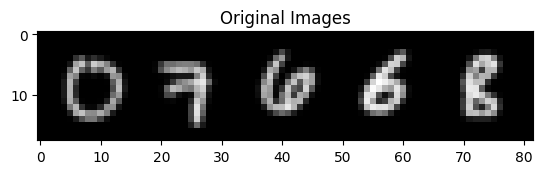

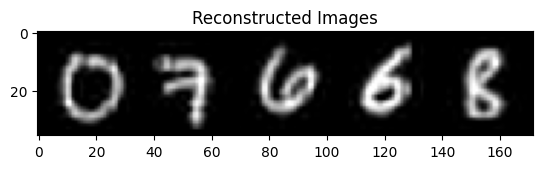

In [15]:
import torchvision
visualize_results(autoencoder, train_dataset)

##### 3.2.2.2 Definición de la CNN mejorada, entrenamiento y visualización de resultados

In [16]:
# Definir el modelo de superresolución adaptado
class SuperResolutionModel(nn.Module):
    def __init__(self):
        super(SuperResolutionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),  # Ajuste el stride para obtener una salida de tamaño 28x28
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Upsample para obtener una salida de tamaño 28x28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [17]:
# Entrenar el modelo
dim = 14
train_dataset, train_loader = download_data(dim)

# Instanciar el modelo
super_resolution_model = SuperResolutionModel()

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(super_resolution_model.parameters(), lr=0.001)
num_epochs = 5

# Entrenar el modelo
train_model(super_resolution_model, criterion, optimizer, dim, num_epochs, train_loader)

Epoch [1/5], Loss: 0.0003
Epoch [2/5], Loss: 0.0001
Epoch [3/5], Loss: 0.0001
Epoch [4/5], Loss: 0.0001
Epoch [5/5], Loss: 0.0001


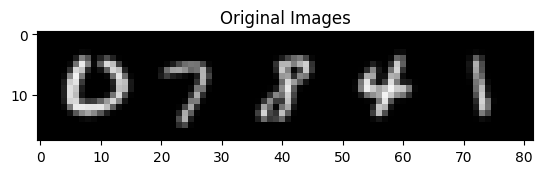

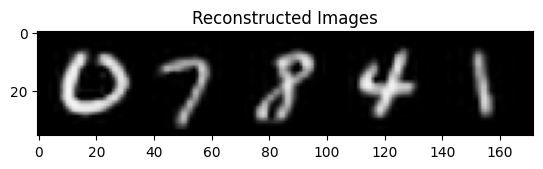

In [18]:
visualize_results(super_resolution_model, train_dataset)


#### 3.2.3 Entrada 28x28 y salida 56x56
##### 3.2.3.1 Definición de la CNN, entrenamiento y visualización de resultados

In [19]:
# Definir el modelo con encoder y decoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            #nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
# Entrenar el modelo
dim = 28
train_dataset, train_loader = download_data(dim)

# Instanciar el modelo
autoencoder = Autoencoder()

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
num_epochs = 10

# Entrenar el modelo
train_model(autoencoder, criterion, optimizer, dim, num_epochs, train_loader)

Epoch [1/10], Loss: 0.0063
Epoch [2/10], Loss: 0.0043
Epoch [3/10], Loss: 0.0033
Epoch [4/10], Loss: 0.0033
Epoch [5/10], Loss: 0.0029
Epoch [6/10], Loss: 0.0029
Epoch [7/10], Loss: 0.0028
Epoch [8/10], Loss: 0.0025
Epoch [9/10], Loss: 0.0023
Epoch [10/10], Loss: 0.0025


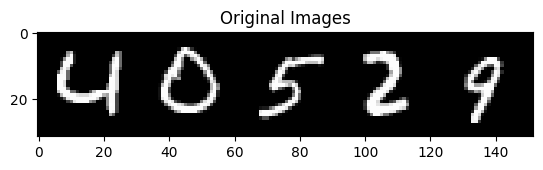

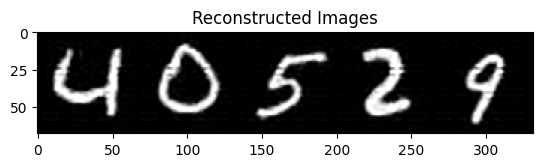

In [21]:
visualize_results(autoencoder, train_dataset)


##### 3.2.3.2 Definición de la CNN mejorada, entrenamiento y visualización de resultados

In [22]:
# Definir el modelo de superresolución adaptado
class SuperResolutionModel(nn.Module):
    def __init__(self):
        super(SuperResolutionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),  # Ajuste el stride para obtener una salida más grande
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Upsample para obtener una salida de tamaño 56x56
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
# Entrenar el modelo
dim = 28
train_dataset, train_loader = download_data(dim)

# Instanciar el modelo
super_resolution_model = SuperResolutionModel()

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(super_resolution_model.parameters(), lr=0.001)
num_epochs = 2

# Entrenar el modelo
train_model(super_resolution_model, criterion, optimizer, dim, num_epochs, train_loader)

Epoch [1/2], Loss: 0.0003
Epoch [2/2], Loss: 0.0001


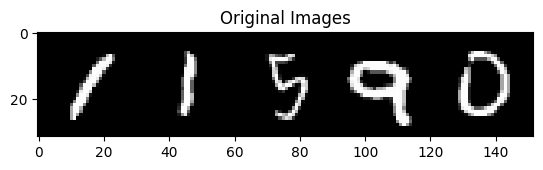

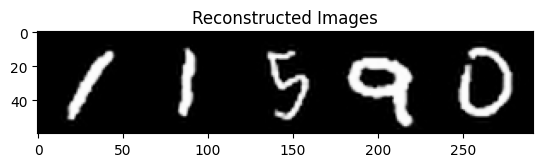

In [24]:
visualize_results(super_resolution_model, train_dataset)